In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from datetime import datetime,timezone
from matplotlib import pyplot as plt
%matplotlib widget

In [3]:
import pandas as pd
datas=[]
def do_label(df, lowerlimit, upperlimit, label):
    # Use boolean indexing to assign the label within the specified timestamp range
    df.loc[(df['timestamp'] >= lowerlimit) & (df['timestamp'] <= upperlimit), 'Label'] = label
    return df

def convert_to_unix_gmt(time):
    time=str(time)
    datetime_string = time
    datetime_object = datetime.strptime(datetime_string, "%Y-%m-%d %H:%M:%S")
    unix_timestamp = int(datetime_object.replace(tzinfo=timezone.utc).timestamp() * 1000)
    return unix_timestamp

def fullextraction():
    study_data = pd.read_csv("dataset/Study_Information.csv")
    
    for i in range(1, 18):
        if i < 10:
            person = "P0" + str(i)
        else:
            person = "P" + str(i)

        path = f"dataset/{person}/EARBUDS/{person}-imu-right.csv"
        data = pd.read_csv(path, low_memory=False)

        data = data.sort_values(by='timestamp', ascending=True)
        data['Label'] = 0

        row = study_data[study_data['Participant'] == person]
        
        data = do_label(data, convert_to_unix_gmt(row["Start_Sit"].values[0]),    convert_to_unix_gmt(row["Start_Stand"].values[0]), 1)
        data = do_label(data, convert_to_unix_gmt(row["Start_Stand"].values[0]),   convert_to_unix_gmt(row["Start_Cycle1"].values[0]), 2)
        data = do_label(data, convert_to_unix_gmt(row["Start_Cycle1"].values[0]),  convert_to_unix_gmt(row["Start_Cycle2"].values[0]), 3)
        data = do_label(data, convert_to_unix_gmt(row["Start_Cycle2"].values[0]),  convert_to_unix_gmt(row["Start_Run1"].values[0]), 4)
        data = do_label(data, convert_to_unix_gmt(row["Start_Run1"].values[0]),    convert_to_unix_gmt(row["Start_Run2"].values[0]), 5)
        data = do_label(data, convert_to_unix_gmt(row["Start_Run2"].values[0]),    (data['timestamp'].iloc[-1]), 6)

        filtered_data = data[data['Label'] != 0]

        print(i)
        print(filtered_data)
        datas.append(filtered_data)
        print(filtered_data['Label'].value_counts())
        filtered_data.to_csv(f"EARBUDS_Labels/{person}-imu-right.csv",index=False)
fullextraction()


1
            timestamp    ax     ay    az  gx   gy  gz  Label
0       1638550730008  2294  16028  1162 -24   41 -58      1
1       1638550730018  2304  16050  1176 -14   28 -53      1
2       1638550730027  2301  16051  1176  -7   12 -40      1
3       1638550730037  2284  16054  1200   1   -8 -36      1
4       1638550730047  2270  16048  1191  10  -26 -28      1
...               ...   ...    ...   ...  ..  ...  ..    ...
191703  1638552570357  3292  15187  4645 -75   67  60      6
191704  1638552570367  3326  15226  4632 -82   70  38      6
191705  1638552570376  3363  15260  4629 -85   97  30      6
191706  1638552570386  3384  15290  4667 -77  134  36      6
191707  1638552570395  3376  15291  4703 -67  149  58      6

[191707 rows x 8 columns]
6    40667
2    31250
4    31250
5    31250
3    31249
1    26041
Name: Label, dtype: int64
2
            timestamp     ax     ay    az  gx  gy  gz  Label
14417   1637860620001  -5062  14397 -5444   2 -48  38      1
14418   1637860620011  

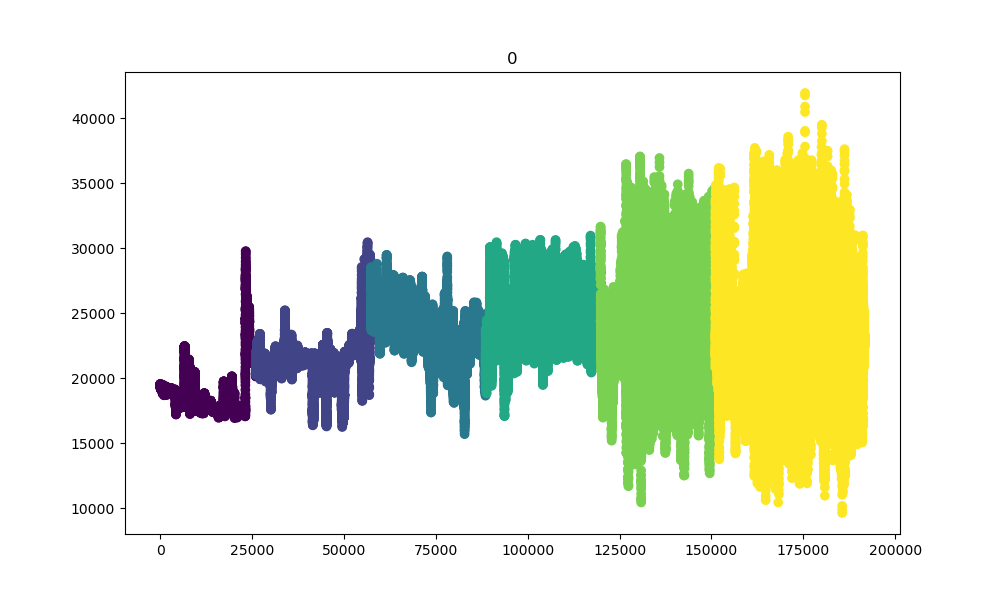

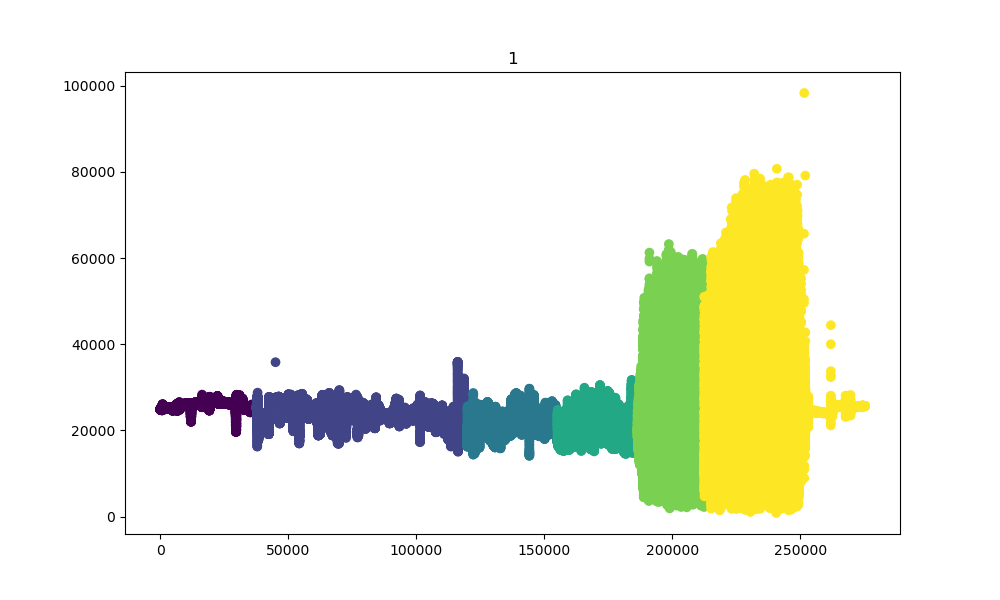

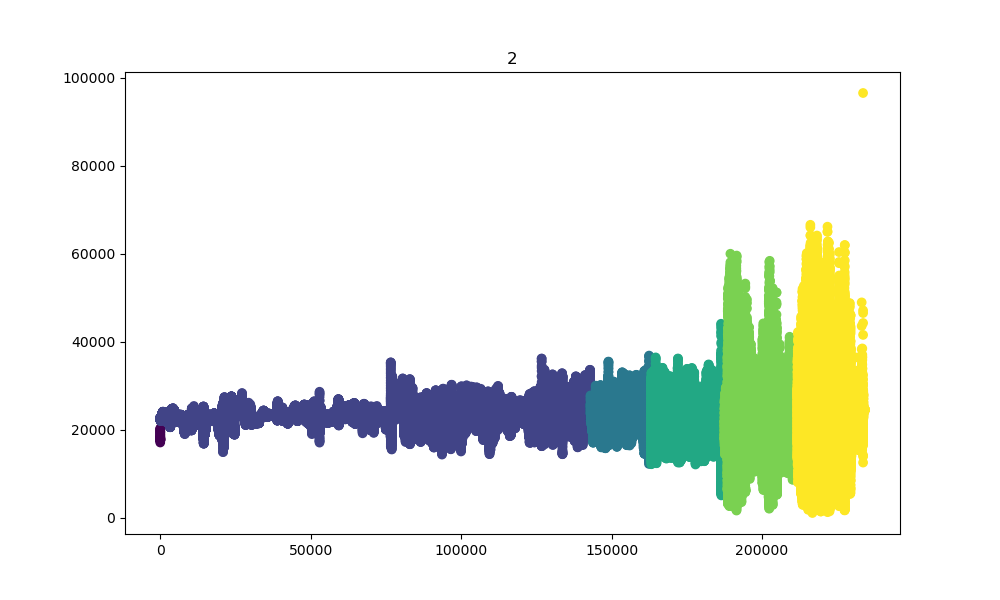

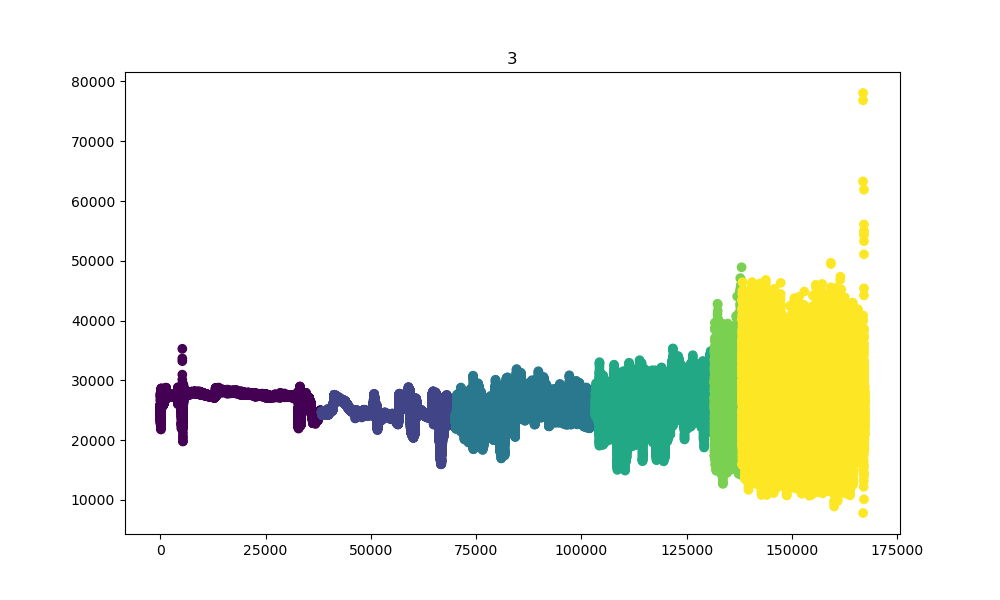

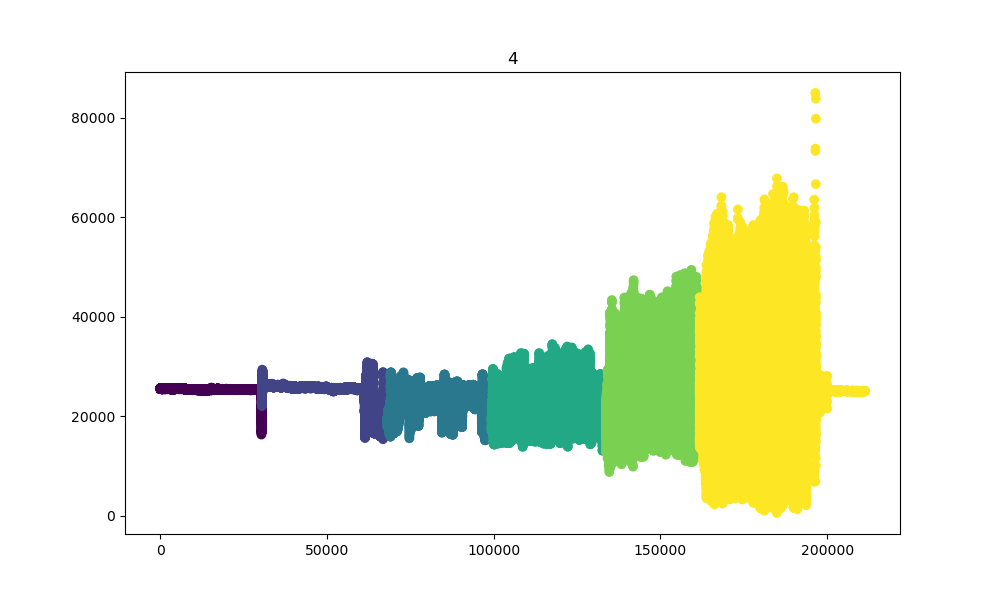

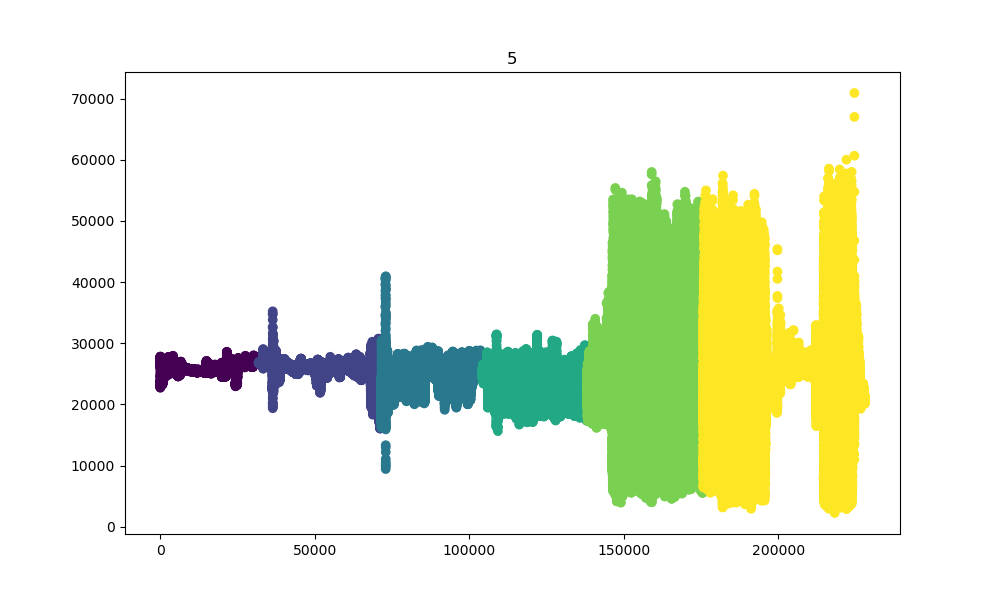

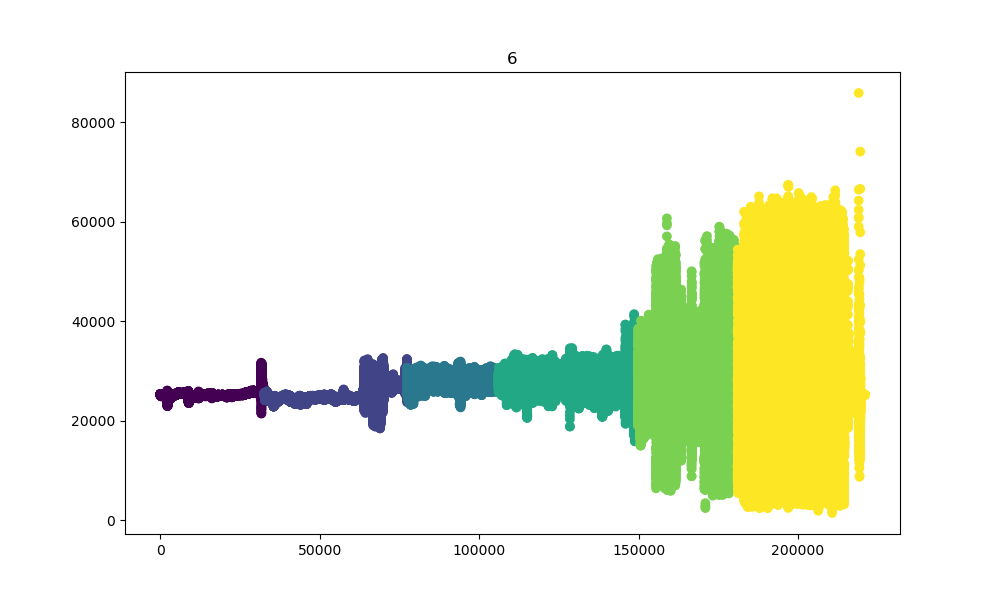

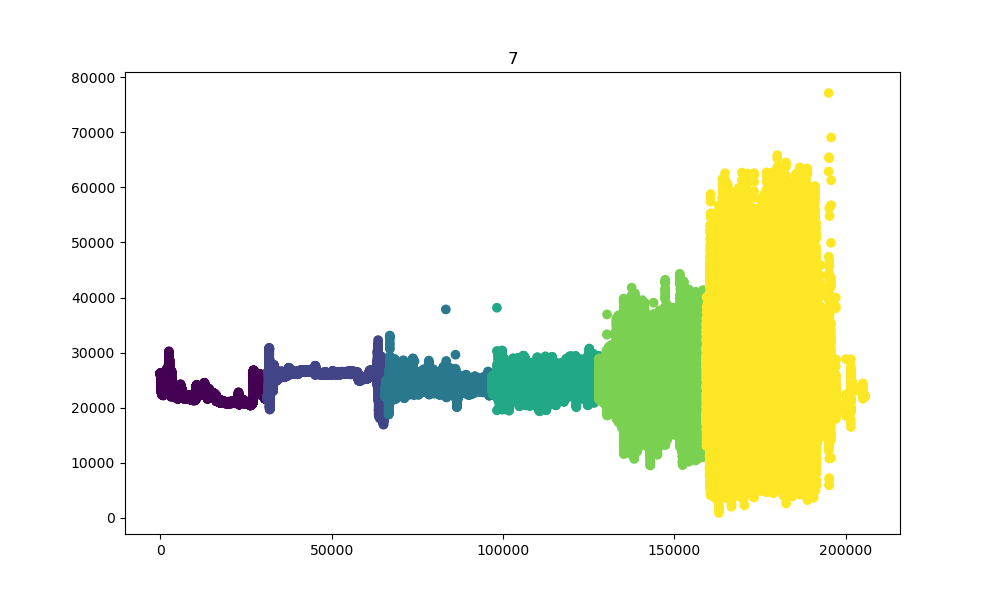

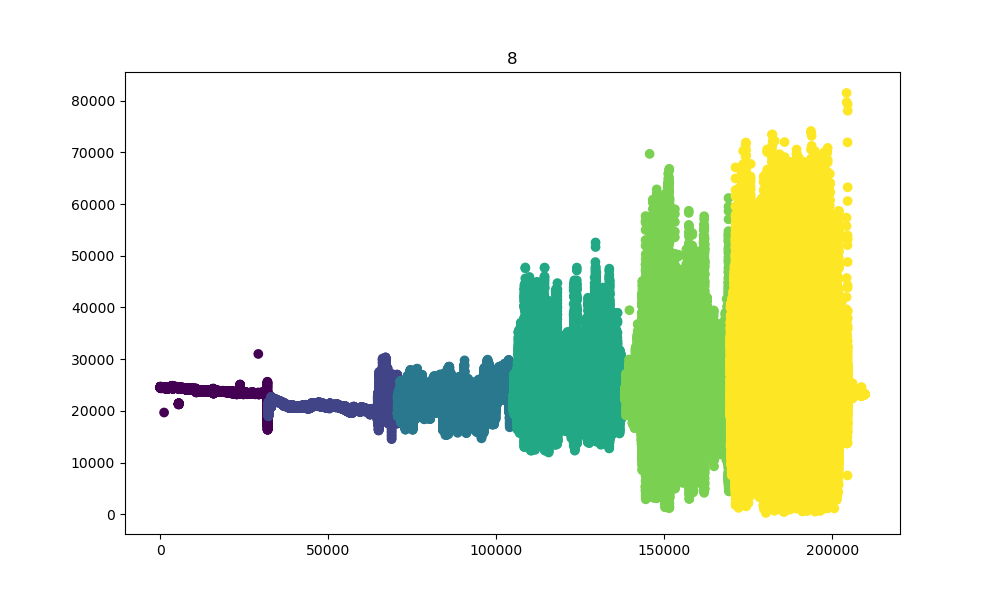

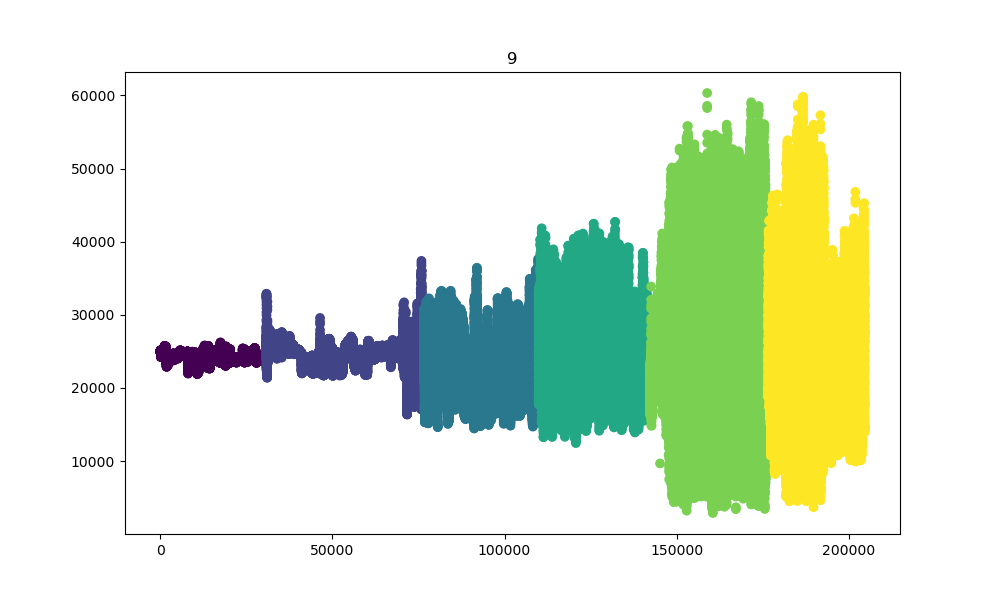

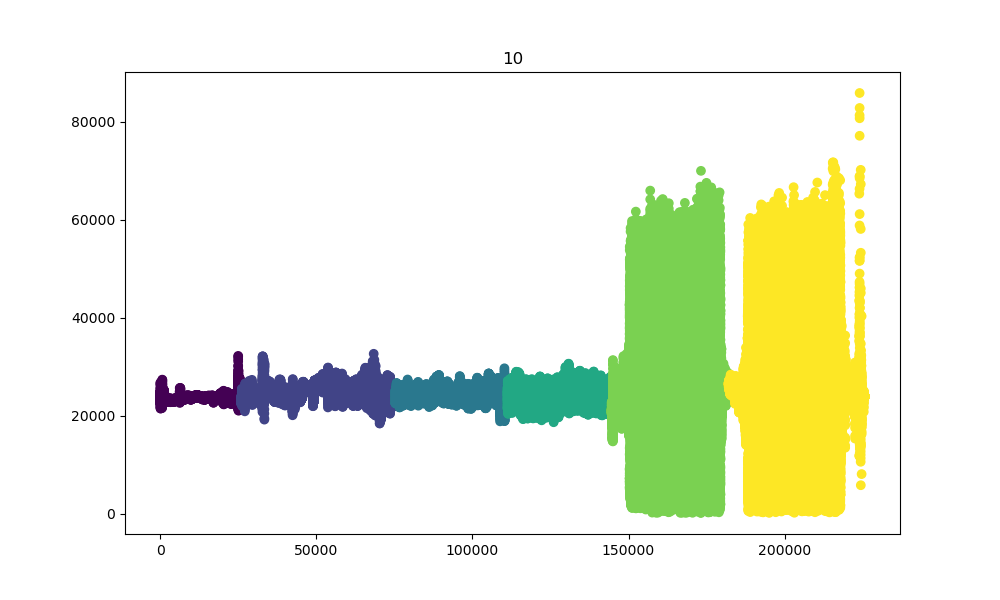

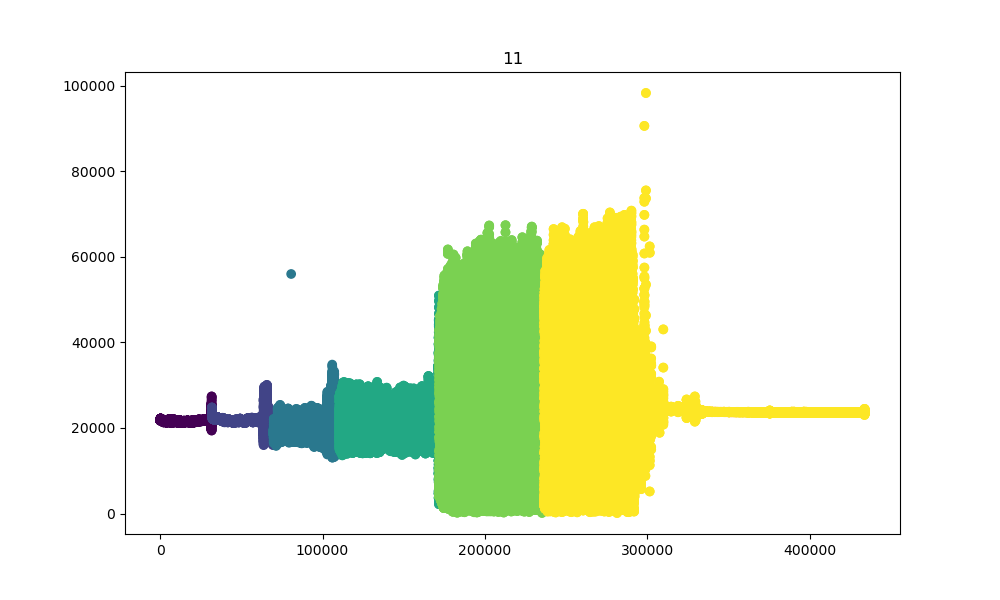

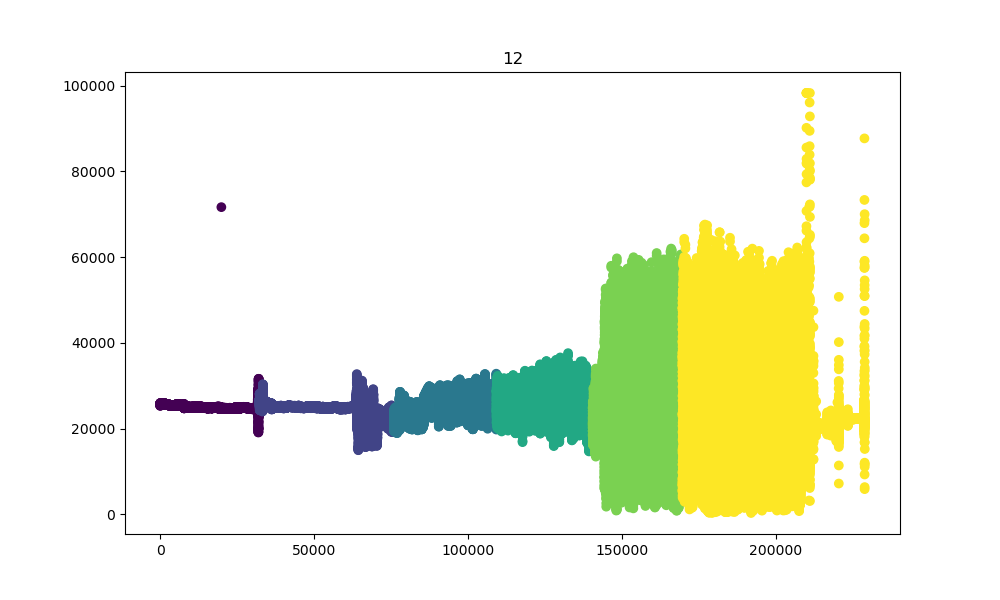

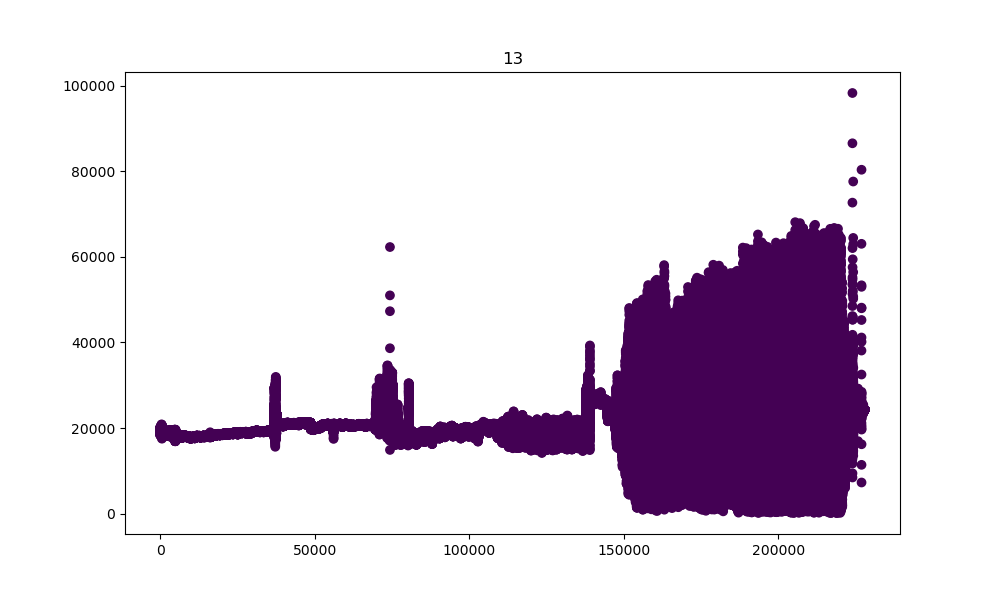

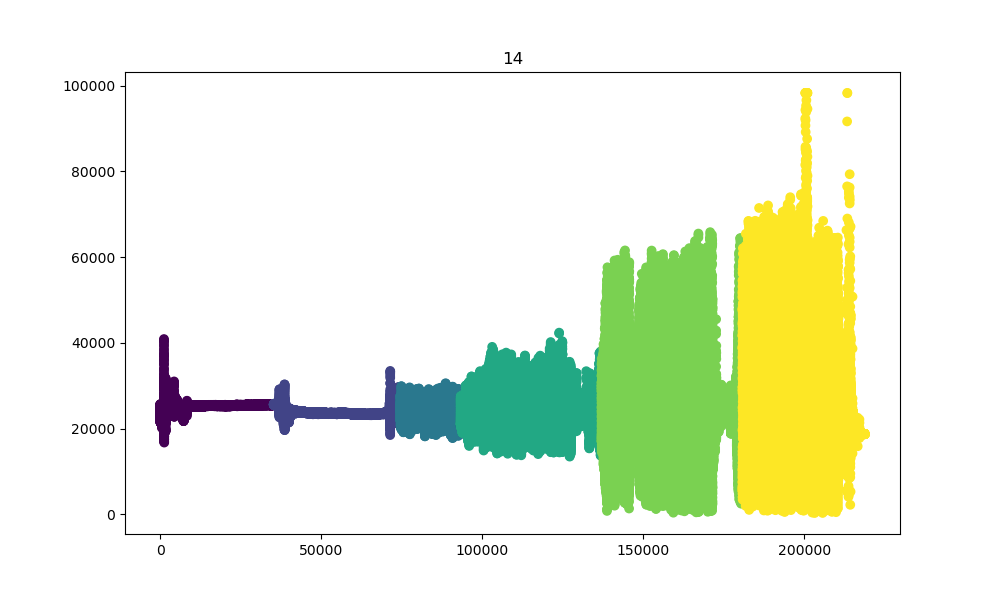

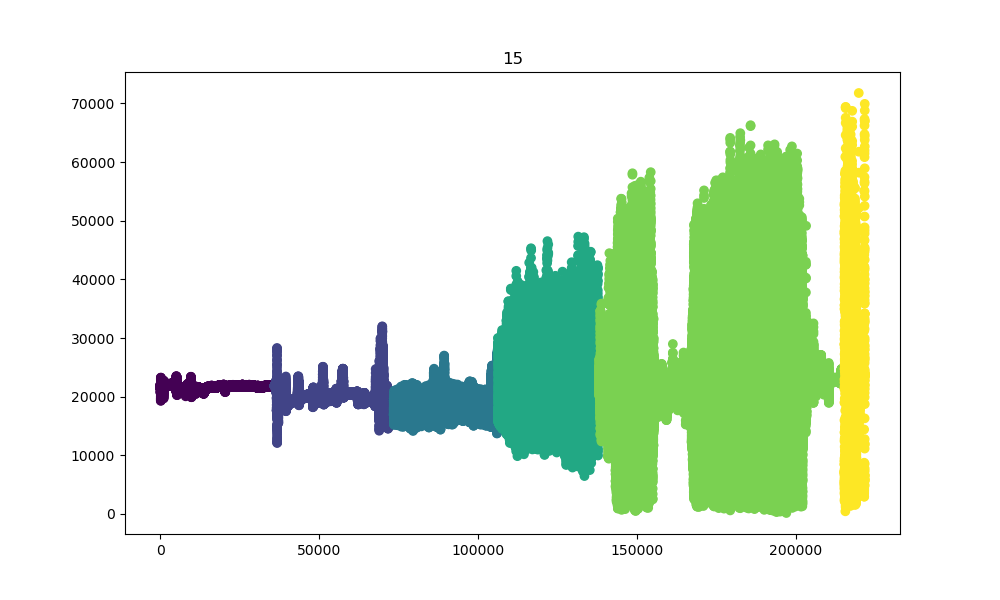

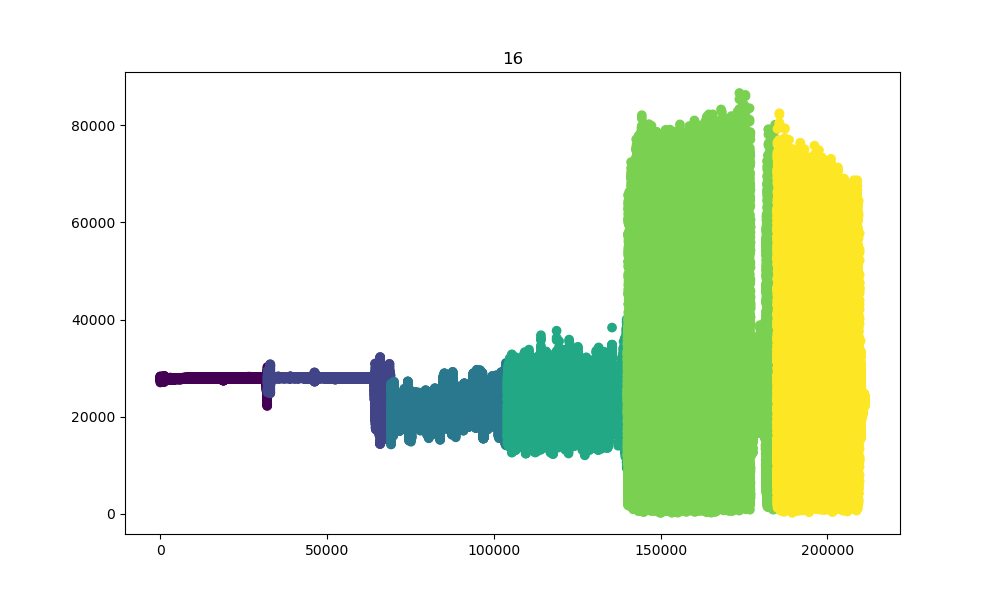

In [4]:
for index,f_data in enumerate(datas):
    x_axis=np.arange(1,len(f_data)+1)
    y_axis=abs(f_data['ax'].values[:])+abs(f_data['az'].values[:])+abs(f_data['ay'].values[:])
    plt.figure(figsize=(10, 6))
    plt.scatter(x_axis,y_axis,c=f_data['Label'],cmap='viridis')
    plt.title(str(index))
    plt.show()

In [19]:
data = pd.read_csv("EARBUDS_Labels/Good/P17-imu-right.csv")
data

,timestamp,ax,ay,az,gx,gy,gz,Label
0,1638464646005,-8303,10700,-8467,-78,-4,-743,1
1,1638464646015,-8468,10791,-8533,39,-9,-714,1
2,1638464646025,-8269,10860,-8430,109,-1,-681,1
3,1638464646034,-8460,11019,-8561,195,-45,-670,1
4,1638464646044,-8286,10977,-8471,214,-42,-664,1
...,...,...,...,...,...,...,...,...
211198,1638466673209,-14536,6128,-2910,1482,419,580,6
211199,1638466673218,-14592,6201,-3083,1377,493,608,6
211200,1638466673228,-14628,6210,-3116,1169,580,637,6
211201,1638466673237,-14652,6185,-3137,1078,562,569,6


In [8]:
from sklearn.ensemble import IsolationForest
co=np.linspace(0.1,0.3,1)
for k in co:
    unique_labels = data['Label'].unique()
    cleaned_data = pd.DataFrame(columns=data.columns)
    for label in unique_labels:
        # Create a subset of data for the current label
        subset = data[data['Label'] == label]
        if(label==6):
            k=0.02
        elif label==5:
            k=0.02
        elif label==4:
            k=0.04
        elif label==3:
            k=0.04
        elif label==2:
            k=0.08
        elif label==1:
            k=0.08
        
        # Apply Isolation Forest to the subset
        isolation_forest = IsolationForest(n_estimators=100,contamination=k)  # Adjust the contamination parameter
        outlier_scores = isolation_forest.fit_predict(subset[['ax', 'ay', 'az', 'gx', 'gy', 'gz']])

        # Filter out anomalies (data points with a score of -1)
        non_anomalous_subset = subset[outlier_scores == 1]

        # Append the non-anomalous subset to the cleaned_data DataFrame
        cleaned_data = pd.concat([cleaned_data, non_anomalous_subset])
    x_axis=np.arange(1,len(cleaned_data)+1)
    y_axis=abs(cleaned_data['ax'].values[:])+abs(cleaned_data['az'].values[:])+abs(cleaned_data['ay'].values[:])
    plt.figure(figsize=(10, 6))
    plt.scatter(x_axis,y_axis,c=cleaned_data['Label'],cmap='viridis')
    plt.title(k)
    plt.show()
    
    cleaned_data.to_csv("EARBUDS_Labels/Cleaned_by_model/P17-imu-right.csv", index =False)

NameError: name 'data' is not defined